<a href="https://colab.research.google.com/github/MOISECHRIST/Machine-Learning/blob/main/TP1_KNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 INF372 : APPRENTISSAGE SUPERVISE ET NON SUPERVISE

## Membre du groupe :
- FOSSI TALLA JORDANE (20U2878)
- MAKOU FOKOUA PATRICIA (21T2446)
- MEKA MOISE CHRISTIAN JUNIOR (21T2561)
- RUDY TCHAMBA TCHAPTCHE ITIEL (21T2981)

Chargement de la

In [3]:
!pip install pykeops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykeops: filename=pykeops-2.2.3-py3-none-any.whl size=118640 sha256=37961179e83714319fdf07bca4ba82462f7fd6c6e7b6e07f4963b2028e614f50
  Stored in directory: /root/.cache/pip/wheels/37/8b/c7/25e5194a7138fd564c3ef3e275ae0155c207cd85d7ab347817
  Created wheel for keopscore: filename=keopscore-2.2.3-py3-none-any.whl size=172486 sha256=bc79798e44de20834fe7e89aed369028826a6602d1ee2df3bb37c58290d54778
  Stored in directory: /root/.cache/pip/wheels/3d/d8/ee/29900acfbbd7ee0f3b05981d3d172baad4c3b5d40cbf4c5d74
Successfully built pykeops keopscore


In [4]:
import time

import torch
from matplotlib import pyplot as plt

from pykeops.torch import LazyTensor

use_cuda = torch.cuda.is_available()
tensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


Chargement des données

In [5]:
try:
    from sklearn.datasets import fetch_openml
except ImportError:
    raise ImportError("This tutorial requires Scikit Learn version >= 0.20.")

mnist = fetch_openml("cifar_10", cache=True, as_frame=False)

x = tensor(mnist.data.astype("float32"))
y = tensor(mnist.target.astype("int64"))

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
<ipython-input-5-d68fe3d3596c>:8: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  x = tensor(mnist.data.astype("float32"))


Séparation des données Train-Test

In [6]:
D = x.shape[1]
Ntrain, Ntest = (50000, 10000) if use_cuda else (1000, 100)
x_train, y_train = x[:Ntrain, :].contiguous(), y[:Ntrain].contiguous()
x_test, y_test = (
    x[Ntrain : Ntrain + Ntest, :].contiguous(),
    y[Ntrain : Ntrain + Ntest].contiguous(),
)

In [7]:
K = 3  # N.B.: K has very little impact on the running time

start = time.time()  # Benchmark:

X_i = LazyTensor(x_test[:, None, :])  # (10000, 1, 784) test set
X_j = LazyTensor(x_train[None, :, :])  # (1, 60000, 784) train set
D_ij = ((X_i - X_j) ** 2).sum(
    -1
)  # (10000, 60000) symbolic matrix of squared L2 distances

ind_knn = D_ij.argKmin(K, dim=1)  # Samples <-> Dataset, (N_test, K)
lab_knn = y_train[ind_knn]  # (N_test, K) array of integers in [0,9]
y_knn, _ = lab_knn.mode()  # Compute the most likely label

if use_cuda:
    torch.cuda.synchronize()
end = time.time()

error = (y_knn != y_test).float().mean().item()
time = end - start

print(
    "{}-NN on the full MNIST dataset: test error = {:.2f}% in {:.2f}s.".format(
        K, error * 100, time
    )
)

[KeOps] Generating code for ArgKMin_Reduction reduction (with parameters 0) of formula Sum((a-b)**2) with a=Var(0,3072,0), b=Var(1,3072,1) ... OK
3-NN on the full MNIST dataset: test error = 66.97% in 3.94s.


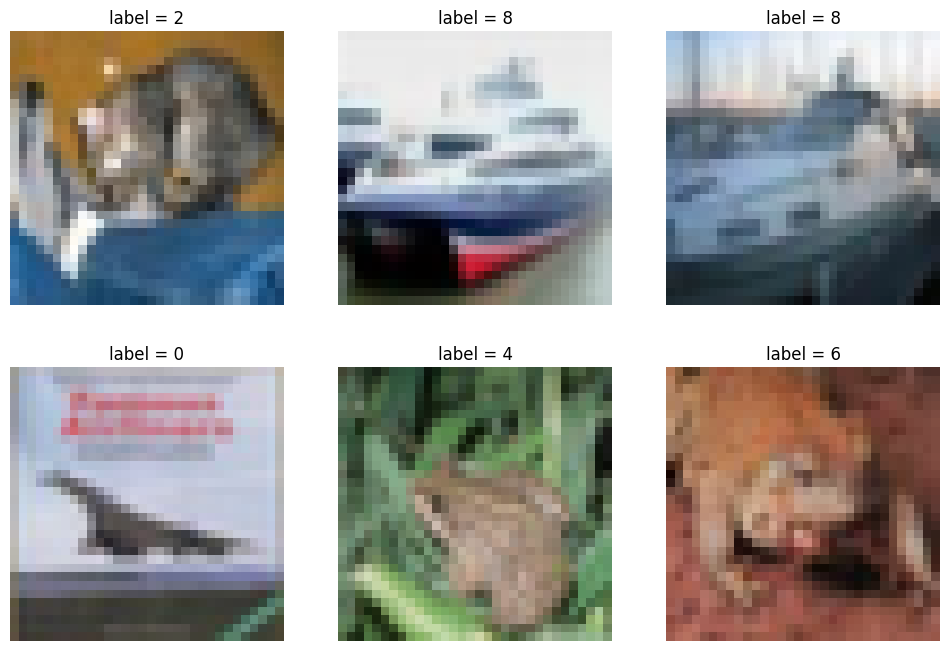

In [8]:
plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(x_test[i].view(3, 32, 32).permute(1, 2, 0).detach().cpu().numpy().astype(int))
    ax.set_title("label = {}".format(y_knn[i].int()))
    plt.axis("off")

plt.show()

In [9]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test.cpu(), y_knn.cpu())

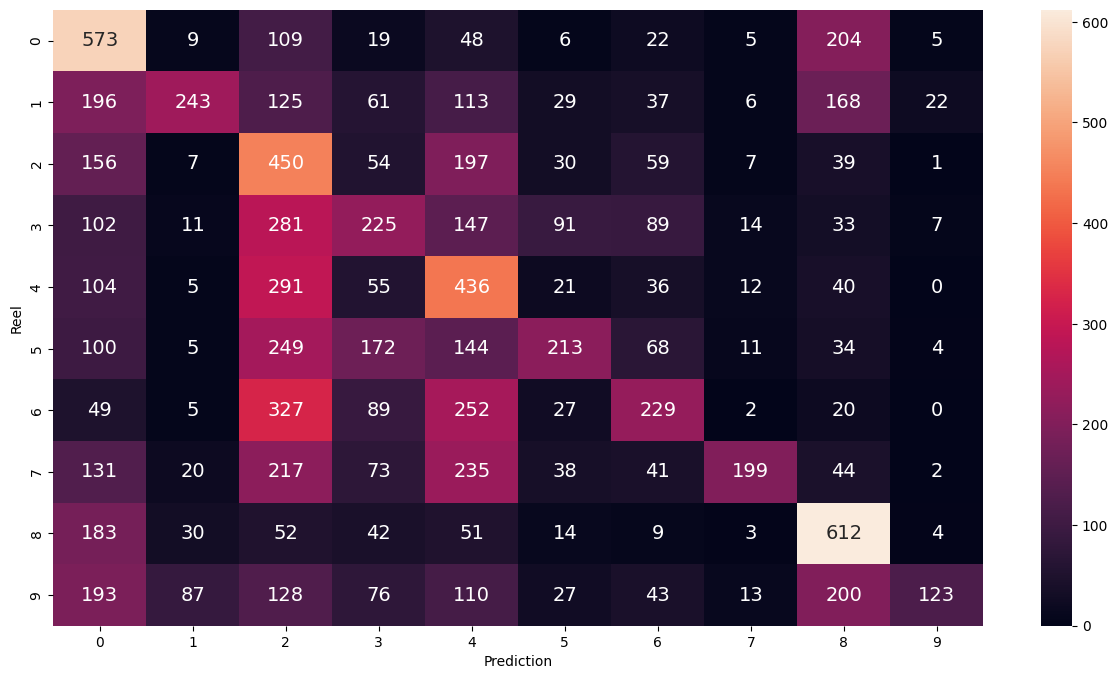

In [10]:
import seaborn as sns
plt.figure(figsize=[15, 8])
sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})
plt.xlabel('Prediction')
plt.ylabel('Reel')
plt.show()